In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [180]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [181]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [182]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [183]:
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [184]:
print(rel.feature_importances_)

[0.13697209 0.48970159 0.27175781 0.10156851]


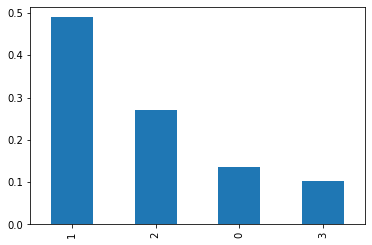

In [185]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [186]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [187]:
ordered_f.head(10)

1    0.326274
2    0.276113
0    0.060894
3    0.039336
dtype: float64

In [188]:
test_ratio = 0.2
seed = 1984
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

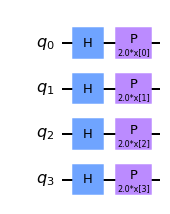

In [189]:
feature_dim = x.shape[1]
emb_layer = 1
ent = 'linear'

fmap = ZFeatureMap(feature_dimension=feature_dim, reps=emb_layer)#, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

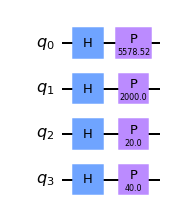

In [190]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

In [191]:
def ansatz_circ(feature_dim, layer, weights):
    ansatz = QuantumCircuit(feature_dim)
    for layer in range(layer):
        for i in range(feature_dim):
            ansatz.ry(weights[i], i)
            ansatz.rz(weights[i+4], i)
        for i in range(feature_dim - 1):
            ansatz.cx(i, i+1)
        ansatz.cx(3,0)
        ansatz.barrier()
    return ansatz

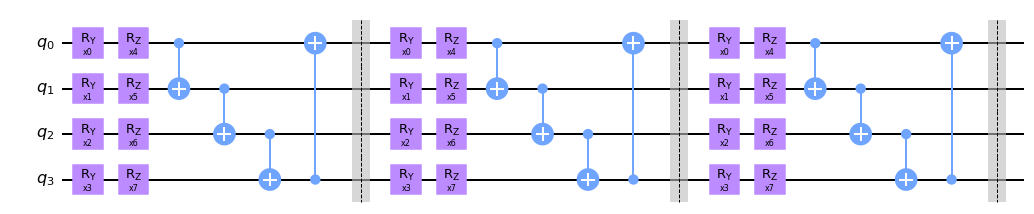

In [192]:
layer = 3
np.random.seed(seed)
nb_w = 8
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

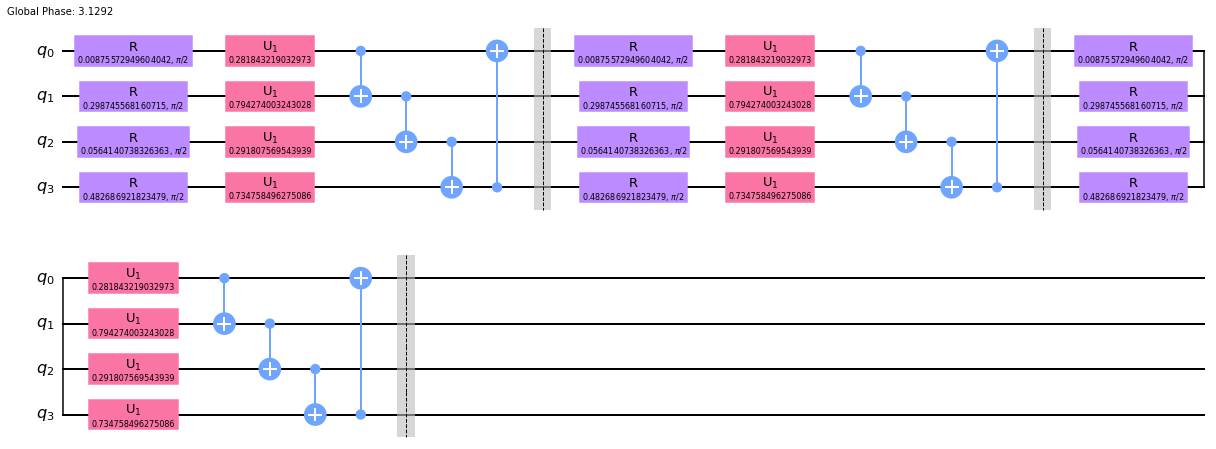

In [193]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

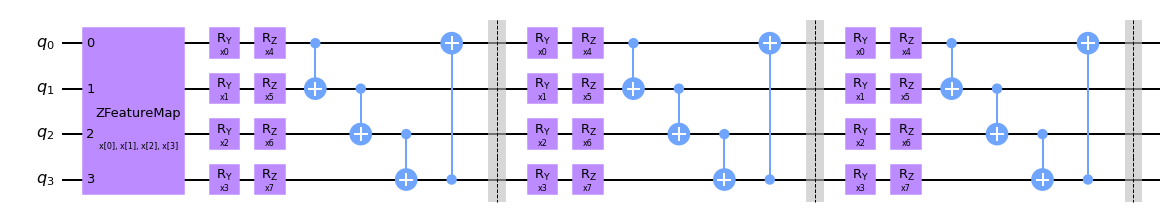

In [194]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [195]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [196]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [197]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [198]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.65234375, 0.34765625]])

In [199]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.00292969,  0.19360352,  0.01806641,  0.1472168 ,
          0.00537109,  0.08764648,  0.02685547, -0.01953125],
        [ 0.00292969, -0.19360352, -0.01806641, -0.1472168 ,
         -0.00537109, -0.08764648, -0.02685547,  0.01953125]]])

In [200]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [201]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [202]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 290.46113203375864
6 - 290.52477827675744
9 - 275.3609046343852
12 - 275.2970607335585
15 - 266.1093145057276
18 - 254.94616370700135
21 - 249.78825233356827
24 - 249.54107004949992
27 - 247.16853615319093
30 - 246.62583501279698
33 - 247.13917087143048
36 - 246.21504907685542
39 - 246.2503605633006
42 - 246.20902750499943
45 - 245.72787708350023
48 - 245.31218874368494
51 - 245.28368978164036
54 - 245.26406546553454
57 - 245.03653257842768
60 - 245.06280599058414
63 - 245.08082576910792
66 - 245.0594269168323
69 - 245.05030731668327
72 - 245.0552992136923
75 - 245.14084228298256
78 - 245.07516054439856
81 - 244.87943659671728
84 - 244.9736549316051
87 - 244.78425417707086
90 - 244.87071324949716
93 - 245.00893513069067
96 - 244.95201719015532
99 - 244.9446058617985
102 - 245.01043127661654
105 - 244.9729852668949
108 - 245.0734686432951
111 - 244.91612156267004
114 - 245.04460789841562
117 - 245.21670417481567
120 - 245.04320118289422
123 - 245.06100538393918
126 - 245.19663362505

In [203]:
score_train_1 = vqc.score(x_train, y_train_1h)
score_test_1 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_1}')
print(f'Score on the test set {score_test_1}')

Score on the train set 0.8066666666666666
Score on the test set 0.825


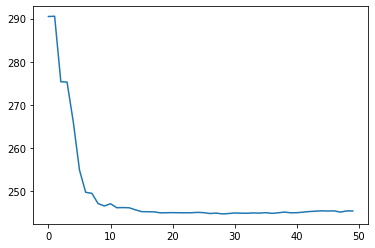

In [204]:
plt.plot(loss_recorder)

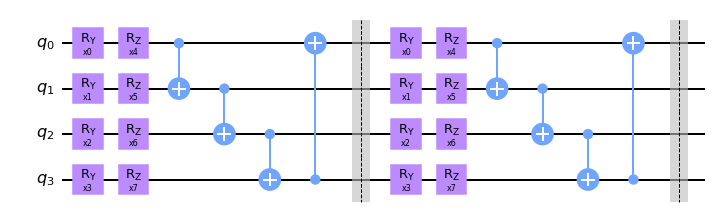

In [205]:
layer = 2
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

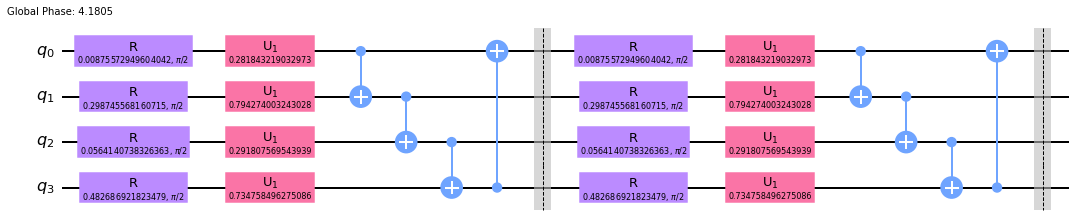

In [206]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

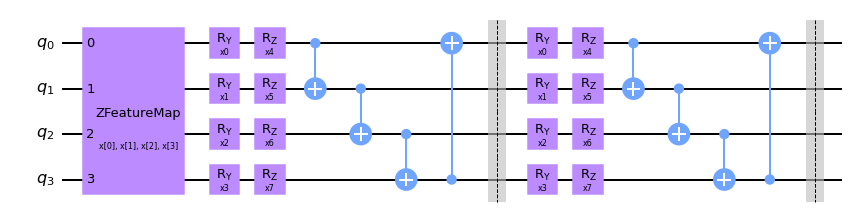

In [207]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [208]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [209]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.50195312, 0.49804688]])

In [210]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.01098633, -0.03710937,  0.0690918 , -0.01000977,
          0.00415039,  0.00585937, -0.04370117, -0.03369141],
        [ 0.01098633,  0.03710937, -0.0690918 ,  0.01000977,
         -0.00415039, -0.00585938,  0.04370117,  0.03369141]]])

In [211]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 538.8997686024728
6 - 299.0636539106792
9 - 301.0338103275266
12 - 300.7332634697371
15 - 311.78018511161656
18 - 357.14440977437215
21 - 311.75545602471857
24 - 305.38011879008303
27 - 310.8023217190022
30 - 312.5793623115813
33 - 313.9383750845999
36 - 299.74006978271603
39 - 299.96990134310295
42 - 299.79920474438677
45 - 299.3139657518604
48 - 299.5156646477234
51 - 299.57899958351777
54 - 301.29145056890763
57 - 296.42415823699116
60 - 296.93193985894425
63 - 297.76004130028423
66 - 296.32536094432203
69 - 295.6972358627287
72 - 296.6015865163077
75 - 297.0857007791834
78 - 296.43237352393794
81 - 295.9509669323926
84 - 296.25018278736763
87 - 295.87424698721725
90 - 294.22193364976687
93 - 294.0428113016388
96 - 293.4637672291178
99 - 293.8349166509794
102 - 293.6746793573234
105 - 293.61531102100764
108 - 293.4559744265364
111 - 293.8056888212311
114 - 292.9456655067735
117 - 292.2154967295483
120 - 292.5155756828792
123 - 292.2465992480561
126 - 290.76003337483246
129 - 290

In [212]:
score_train_2 = vqc.score(x_train, y_train_1h)
score_test_2 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_2}')
print(f'Score on the test set {score_test_2}')

Score on the train set 0.5933333333333334
Score on the test set 0.43333333333333335


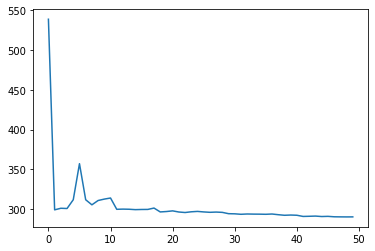

In [213]:
plt.plot(loss_recorder)

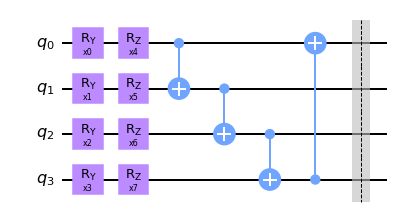

In [214]:
layer = 1
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

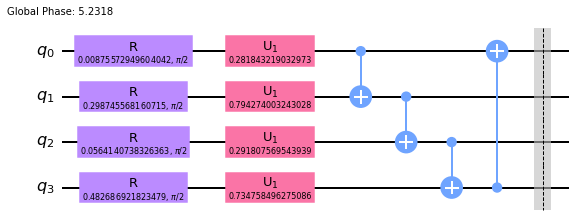

In [215]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

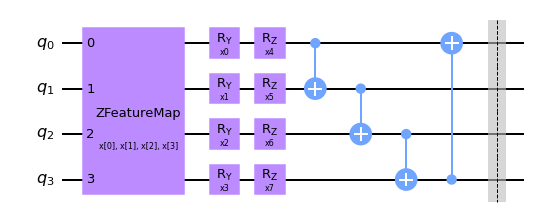

In [216]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [217]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [218]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.51025391, 0.48974609]])

In [219]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.01025391,  0.00073242, -0.00488281, -0.01367187,
         -0.01000977,  0.0012207 , -0.00390625, -0.0090332 ],
        [ 0.01025391, -0.00073242,  0.00488281,  0.01367187,
          0.01000977, -0.0012207 ,  0.00390625,  0.0090332 ]]])

In [220]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 293.5806847246861
6 - 296.3186297480791
9 - 301.9419486805439
12 - 300.3452278144244
15 - 307.59955790569245
18 - 307.9268512054963
21 - 297.05975886556655
24 - 295.1947722654263
27 - 295.7487281681374
30 - 294.41268757534726
33 - 294.36813025462885
36 - 293.7368768141182
39 - 294.08241485876744
42 - 293.9033770178154
45 - 293.8960986973859
48 - 293.62568591444006
51 - 293.66358395730174
54 - 293.624877783704
57 - 293.58865623723193
60 - 293.55547916733866
63 - 293.75177177711305
66 - 293.80441906306953
69 - 293.8242719816749
72 - 293.5844118661597
75 - 293.57906579869274
78 - 292.9651931567318
81 - 293.2044723988716
84 - 293.46507767289495
87 - 293.0332471721558
90 - 293.3555885206802
93 - 293.0806489471876
96 - 292.7559585807552
99 - 292.9236382899379
102 - 292.81639083267464
105 - 292.9340124102156
108 - 292.8116883619613
111 - 292.824880422241
114 - 292.8731689317042
117 - 292.90314797069334
120 - 292.8561010203817
123 - 292.793308821421
126 - 292.73323576455186
129 - 292.72577

In [221]:
score_train_3 = vqc.score(x_train, y_train_1h)
score_test_3 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_3}')
print(f'Score on the test set {score_test_3}')

Score on the train set 0.5866666666666667
Score on the test set 0.4583333333333333


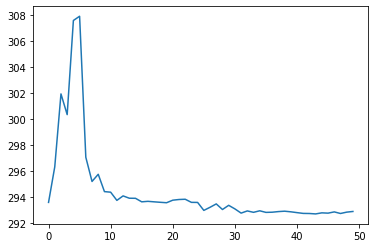

In [222]:
plt.plot(loss_recorder)